![image.png](./image.png "image.png")

### Deployment de Modelo de Classificação com Scikit-Learn Usando MLflow, Features e Logs

In [0]:
# Substitua o catálogo e o schema que irá usar e crie
CATALOG_NAME = "baraldi_catalog_new"
SCHEMA_NAME = "classification"

spark.sql(f"CREATE CATALOG IF NOT EXISTS {CATALOG_NAME}")
spark.sql(f"CREATE SCHEMA IF NOT EXISTS {CATALOG_NAME}.{SCHEMA_NAME}")

DataFrame[]

In [0]:
# Instale as bibliotecas necessárias
%pip install hyperopt

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
# Importe as bibliotecas a serem utilizadas e configure-as
import numpy as np

import pandas as pd

import sklearn.metrics
import sklearn.model_selection
import sklearn.ensemble
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

from hyperopt import fmin, tpe, hp, SparkTrials, Trials, STATUS_OK
from hyperopt.pyll import scope

import mlflow
from mlflow.deployments import get_deploy_client
mlflow.set_registry_uri("databricks-uc")

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fe0c765e7a0>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.12/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'split'


In [0]:
# Carregue o dataset dataset_disease.csv no Workspace, passe para a variável e escreva como uma Delta table chamada 'dataset_disease'
data=pd.read_csv("/Workspace/Users/daniel.baraldi@databricks.com/LaboratorioDatabricks/dataset_saude_lab.csv")
spark.sql(f"DROP TABLE IF EXISTS {CATALOG_NAME}.{SCHEMA_NAME}.dataset_disease")
spark.createDataFrame(data).write.saveAsTable(f"{CATALOG_NAME}.{SCHEMA_NAME}.dataset_disease")

In [0]:
# Visualize os dados da tabela Delta
data_analyze=spark.read.table(f"{CATALOG_NAME}.{SCHEMA_NAME}.dataset_disease")
display(data_analyze)

id idade sexo pressao_sistolica pressao_diastolica colesterol batimento imc glicose tabagismo doenca_cardiaca 1 59.0 F 156.0 105.0 254.0 72.0 27.7 182.0 1 1 2 65.0 M 162.0 86.0 217.0 71.0 28.1 216.0 1 1 3 60.0 M 120.0 86.0 204.0 87.0 23.8 97.0 1 0 4 34.0 M 142.0 81.0 167.0 75.0 18.4 104.0 1 0 5 46.0 M 147.0 76.0 236.0 85.0 24.7 112.0 0 0 6 59.0 M 179.0 94.0 219.0 82.0 28.1 143.0 0 1 7 56.0 F 131.0 94.0 218.0 64.0 27.3 119.0 0 0 8 52.0 M 140.0 110.0 196.0 58.0 30.5 125.0 1 1 9 49.0 M 115.0 91.0 222.0 63.0 30.3 78.0 0 0 10 60.0 M 133.0 70.0 206.0 71.0 30.4 193.0 0 1 11 53.0 F 169.0 95.0 249.0 76.0 27.2 158.0 0 1 12 41.0 F 110.0 85.0 231.0 69.0 25.2 100.0 0 0 13 51.0 M 148.0 94.0 188.0 82.0 27.9 121.0 1 0 14 59.0 F 137.0 97.0 204.0 70.0 21.1 195.0 0 1 15 56.0 F 120.0 98.0 212.0 78.0 22.1 90.0 0 0 16 37.0 F 128.0 89.0 166.0 76.0 22.2 115.0 1 0 17 46.0 F 119.0 101.0 181.0 92.0 26.6 75.0 1 0 18 58.0 F 164.0 91.0 249.0 65.0 32.6 136.0 1 1 19 68.0 F 177.0 96.0 288.0 97.0 30.5 158.0 1 1 20 39.0 F 120.0 93.0 196.0 69.0 18.0 82.0 0 0 21 53.0 M 124.0 79.0 196.0 62.0 18.4 105.0 0 0 22 63.0 M 148.0 87.0 266.0 73.0 28.8 164.0 1 1 23 76.0 F 158.0 89.0 242.0 107.0 27.5 158.0 0 1 24 38.0 M 128.0 78.0 217.0 84.0 25.0 81.0 0 0 25 42.0 M 151.0 90.0 233.0 81.0 23.1 119.0 0 0 26 39.0 F 147.0 70.0 184.0 83.0 31.1 124.0 1 0 27 43.0 M 132.0 79.0 140.0 67.0 18.5 143.0 1 1 28 71.0 F 138.0 104.0 166.0 78.0 26.2 137.0 0 0 29 35.0 F 153.0 78.0 237.0 75.0 28.3 95.0 1 0 30 40.0 F 123.0 87.0 194.0 93.0 27.8 120.0 0 0 31 66.0 M 126.0 70.0 183.0 74.0 28.1 81.0 0 0 32 42.0 M 142.0 96.0 281.0 71.0 34.7 92.0 0 1 33 68.0 M 142.0 88.0 236.0 63.0 27.0 163.0 1 1 34 46.0 M 125.0 79.0 167.0 76.0 24.5 141.0 0 1 35 65.0 F 110.0 98.0 142.0 78.0 18.0 98.0 0 0 36 30.0 F 131.0 97.0 210.0 63.0 23.5 83.0 0 0 37 30.0 M 153.0 84.0 193.0 80.0 21.9 131.0 0 0 38 43.0 F 121.0 95.0 246.0 77.0 29.6 72.0 0 0 39 62.0 F 120.0 104.0 169.0 85.0 23.8 135.0 0 0 40 60.0 M 176.0 103.0 229.0 87.0 24.8 154.0 0 1 41 57.0 F 133.0 100.0 209.0 76.0 24.1 96.0 0 1 42 66.0 M 110.0 87.0 177.0 65.0 33.0 113.0 1 0 43 80.0 F 138.0 101.0 174.0 67.0 29.9 220.0 0 1 44 58.0 M 120.0 81.0 182.0 93.0 21.9 140.0 0 0 45 54.0 F 124.0 92.0 238.0 77.0 30.6 115.0 0 1 46 45.0 F 128.0 90.0 190.0 92.0 32.6 128.0 1 0 47 35.0 M 144.0 80.0 270.0 80.0 23.4 75.0 0 0 48 51.0 M 111.0 81.0 259.0 83.0 27.7 76.0 0 0 49 30.0 M 131.0 85.0 169.0 84.0 29.7 108.0 1 0 50 57.0 M 136.0 97.0 140.0 63.0 18.0 124.0 0 0 51 80.0 F 149.0 84.0 237.0 78.0 26.8 164.0 0 1 52 67.0 F 153.0 103.0 253.0 63.0 35.3 165.0 0 1 53 44.0 M 133.0 93.0 165.0 72.0 22.2 122.0 0 0 54 56.0 F 118.0 93.0 167.0 81.0 26.7 70.0 1 0 55 76.0 M 172.0 87.0 295.0 65.0 26.2 138.0 0 1 56 69.0 M 149.0 70.0 186.0 81.0 23.2 134.0 0 0 57 50.0 F 168.0 101.0 263.0 60.0 27.2 153.0 0 1 58 65.0 F 165.0 97.0 207.0 86.0 33.2 145.0 0 1 59 58.0 M 126.0 105.0 238.0 68.0 31.0 150.0 0 1 60 60.0 M 144.0 78.0 183.0 65.0 25.4 118.0 0 0 61 55.0 M 140.0 93.0 171.0 61.0 35.0 70.0 0 0 62 30.0 F 110.0 96.0 235.0 69.0 32.0 139.0 0 0 63 46.0 F 127.0 84.0 146.0 56.0 18.0 107.0 0 0 64 52.0 F 134.0 89.0 206.0 70.0 23.2 128.0 0 0 65 33.0 F 155.0 89.0 183.0 86.0 34.7 70.0 0 0 66 66.0 M 161.0 87.0 255.0 73.0 27.1 190.0 0 1 67 32.0 M 117.0 90.0 183.0 63.0 33.4 81.0 1 0 68 40.0 M 155.0 101.0 225.0 77.0 23.3 174.0 0 0 69 66.0 M 131.0 85.0 162.0 76.0 24.1 163.0 0 0 70 39.0 M 126.0 70.0 236.0 95.0 28.5 77.0 0 0 71 57.0 M 125.0 78.0 194.0 83.0 24.6 130.0 0 0 72 30.0 F 110.0 70.0 149.0 78.0 27.0 85.0 1 0 73 80.0 F 148.0 108.0 264.0 84.0 37.9 121.0 0 1 74 46.0 M 137.0 93.0 188.0 74.0 28.0 95.0 1 0 75 51.0 M 124.0 80.0 140.0 74.0 25.6 121.0 1 0 76 52.0 F 136.0 71.0 207.0 92.0 31.7 118.0 0 0 77 57.0 F 117.0 77.0 230.0 59.0 28.5 80.0 0 0 78 32.0 F 128.0 79.0 240.0 85.0 22.1 121.0 0 0 79 60.0 F 155.0 96.0 227.0 74.0 39.9 134.0 1 1 80 53.0 M 153.0 96.0 245.0 72.0 33.2 85.0 0 1 81 43.0 M 126.0 108.0 242.0 69.0 28.9 127.0 0 1 82 62.0 M 123.0 78.0 247.0 77.0 18.0 152.0 0 0 83 56.0 M 175.0 80.0 212.0 75.0 23.1 128.0 0 1 84 53.0

Databricks data profile. Run in Databricks to view.

Databricks visualization. Run in Databricks to view.

Databricks visualization. Run in Databricks to view.

In [0]:
# Perceba que a tabela Delta apresenta uma série de recursos

![Delta.png](./Delta.png "Delta.png")

In [0]:
# É possível também criar descrições e comentários nas colunas usando GenAI

![TableData.png](./TableData.png "TableData.png")

In [0]:
# Transforme no formato padrão do Pandas
data_analyze_pandas=data_analyze.toPandas()

# Inicialize o OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Substitua o sexo de F e M pelas versões com one hot encoding e renomeie a coluna
data_analyze_pandas["sexo"] = encoder.fit_transform(data_analyze_pandas[["sexo"]])
data_analyze_pandas.rename(columns={'sexo': 'sexo_feminino'}, inplace=True)

#Realize o drop da coluna id e doenca_cardiaca para manter features
data_analyze_pandas.drop("id", axis=1, inplace=True)
data_analyze_pandas_features=data_analyze_pandas.drop("doenca_cardiaca", axis=1)

# Crie a coluna de labels
data_labels = data_analyze_pandas['doenca_cardiaca']

# Visualize o resultado
display(data_analyze_pandas)
display(data_analyze_pandas_features)
display(data_labels)

idade sexo_feminino pressao_sistolica pressao_diastolica colesterol batimento imc glicose tabagismo doenca_cardiaca 59.0 1.0 156.0 105.0 254.0 72.0 27.7 182.0 1 1 65.0 0.0 162.0 86.0 217.0 71.0 28.1 216.0 1 1 60.0 0.0 120.0 86.0 204.0 87.0 23.8 97.0 1 0 34.0 0.0 142.0 81.0 167.0 75.0 18.4 104.0 1 0 46.0 0.0 147.0 76.0 236.0 85.0 24.7 112.0 0 0 59.0 0.0 179.0 94.0 219.0 82.0 28.1 143.0 0 1 56.0 1.0 131.0 94.0 218.0 64.0 27.3 119.0 0 0 52.0 0.0 140.0 110.0 196.0 58.0 30.5 125.0 1 1 49.0 0.0 115.0 91.0 222.0 63.0 30.3 78.0 0 0 60.0 0.0 133.0 70.0 206.0 71.0 30.4 193.0 0 1 53.0 1.0 169.0 95.0 249.0 76.0 27.2 158.0 0 1 41.0 1.0 110.0 85.0 231.0 69.0 25.2 100.0 0 0 51.0 0.0 148.0 94.0 188.0 82.0 27.9 121.0 1 0 59.0 1.0 137.0 97.0 204.0 70.0 21.1 195.0 0 1 56.0 1.0 120.0 98.0 212.0 78.0 22.1 90.0 0 0 37.0 1.0 128.0 89.0 166.0 76.0 22.2 115.0 1 0 46.0 1.0 119.0 101.0 181.0 92.0 26.6 75.0 1 0 58.0 1.0 164.0 91.0 249.0 65.0 32.6 136.0 1 1 68.0 1.0 177.0 96.0 288.0 97.0 30.5 158.0 1 1 39.0 1.0 120.0 93.0 196.0 69.0 18.0 82.0 0 0 53.0 0.0 124.0 79.0 196.0 62.0 18.4 105.0 0 0 63.0 0.0 148.0 87.0 266.0 73.0 28.8 164.0 1 1 76.0 1.0 158.0 89.0 242.0 107.0 27.5 158.0 0 1 38.0 0.0 128.0 78.0 217.0 84.0 25.0 81.0 0 0 42.0 0.0 151.0 90.0 233.0 81.0 23.1 119.0 0 0 39.0 1.0 147.0 70.0 184.0 83.0 31.1 124.0 1 0 43.0 0.0 132.0 79.0 140.0 67.0 18.5 143.0 1 1 71.0 1.0 138.0 104.0 166.0 78.0 26.2 137.0 0 0 35.0 1.0 153.0 78.0 237.0 75.0 28.3 95.0 1 0 40.0 1.0 123.0 87.0 194.0 93.0 27.8 120.0 0 0 66.0 0.0 126.0 70.0 183.0 74.0 28.1 81.0 0 0 42.0 0.0 142.0 96.0 281.0 71.0 34.7 92.0 0 1 68.0 0.0 142.0 88.0 236.0 63.0 27.0 163.0 1 1 46.0 0.0 125.0 79.0 167.0 76.0 24.5 141.0 0 1 65.0 1.0 110.0 98.0 142.0 78.0 18.0 98.0 0 0 30.0 1.0 131.0 97.0 210.0 63.0 23.5 83.0 0 0 30.0 0.0 153.0 84.0 193.0 80.0 21.9 131.0 0 0 43.0 1.0 121.0 95.0 246.0 77.0 29.6 72.0 0 0 62.0 1.0 120.0 104.0 169.0 85.0 23.8 135.0 0 0 60.0 0.0 176.0 103.0 229.0 87.0 24.8 154.0 0 1 57.0 1.0 133.0 100.0 209.0 76.0 24.1 96.0 0 1 66.0 0.0 110.0 87.0 177.0 65.0 33.0 113.0 1 0 80.0 1.0 138.0 101.0 174.0 67.0 29.9 220.0 0 1 58.0 0.0 120.0 81.0 182.0 93.0 21.9 140.0 0 0 54.0 1.0 124.0 92.0 238.0 77.0 30.6 115.0 0 1 45.0 1.0 128.0 90.0 190.0 92.0 32.6 128.0 1 0 35.0 0.0 144.0 80.0 270.0 80.0 23.4 75.0 0 0 51.0 0.0 111.0 81.0 259.0 83.0 27.7 76.0 0 0 30.0 0.0 131.0 85.0 169.0 84.0 29.7 108.0 1 0 57.0 0.0 136.0 97.0 140.0 63.0 18.0 124.0 0 0 80.0 1.0 149.0 84.0 237.0 78.0 26.8 164.0 0 1 67.0 1.0 153.0 103.0 253.0 63.0 35.3 165.0 0 1 44.0 0.0 133.0 93.0 165.0 72.0 22.2 122.0 0 0 56.0 1.0 118.0 93.0 167.0 81.0 26.7 70.0 1 0 76.0 0.0 172.0 87.0 295.0 65.0 26.2 138.0 0 1 69.0 0.0 149.0 70.0 186.0 81.0 23.2 134.0 0 0 50.0 1.0 168.0 101.0 263.0 60.0 27.2 153.0 0 1 65.0 1.0 165.0 97.0 207.0 86.0 33.2 145.0 0 1 58.0 0.0 126.0 105.0 238.0 68.0 31.0 150.0 0 1 60.0 0.0 144.0 78.0 183.0 65.0 25.4 118.0 0 0 55.0 0.0 140.0 93.0 171.0 61.0 35.0 70.0 0 0 30.0 1.0 110.0 96.0 235.0 69.0 32.0 139.0 0 0 46.0 1.0 127.0 84.0 146.0 56.0 18.0 107.0 0 0 52.0 1.0 134.0 89.0 206.0 70.0 23.2 128.0 0 0 33.0 1.0 155.0 89.0 183.0 86.0 34.7 70.0 0 0 66.0 0.0 161.0 87.0 255.0 73.0 27.1 190.0 0 1 32.0 0.0 117.0 90.0 183.0 63.0 33.4 81.0 1 0 40.0 0.0 155.0 101.0 225.0 77.0 23.3 174.0 0 0 66.0 0.0 131.0 85.0 162.0 76.0 24.1 163.0 0 0 39.0 0.0 126.0 70.0 236.0 95.0 28.5 77.0 0 0 57.0 0.0 125.0 78.0 194.0 83.0 24.6 130.0 0 0 30.0 1.0 110.0 70.0 149.0 78.0 27.0 85.0 1 0 80.0 1.0 148.0 108.0 264.0 84.0 37.9 121.0 0 1 46.0 0.0 137.0 93.0 188.0 74.0 28.0 95.0 1 0 51.0 0.0 124.0 80.0 140.0 74.0 25.6 121.0 1 0 52.0 1.0 136.0 71.0 207.0 92.0 31.7 118.0 0 0 57.0 1.0 117.0 77.0 230.0 59.0 28.5 80.0 0 0 32.0 1.0 128.0 79.0 240.0 85.0 22.1 121.0 0 0 60.0 1.0 155.0 96.0 227.0 74.0 39.9 134.0 1 1 53.0 0.0 153.0 96.0 245.0 72.0 33.2 85.0 0 1 43.0 0.0 126.0 108.0 242.0 69.0 28.9 127.0 0 1 62.0 0.0 123.0 78.0 247.0 77.0 18.0 152.0 0 0 56.0 0.0 175.0 80.0 212.0 75.0 23.1 128.0 0 1 53.0 0.0 123.0 73.0 179.0 71.0 31.8 70.0 0 0 52.0 1.0 130.0 85.0 166.0 68.0

idade sexo_feminino pressao_sistolica pressao_diastolica colesterol batimento imc glicose tabagismo 59.0 1.0 156.0 105.0 254.0 72.0 27.7 182.0 1 65.0 0.0 162.0 86.0 217.0 71.0 28.1 216.0 1 60.0 0.0 120.0 86.0 204.0 87.0 23.8 97.0 1 34.0 0.0 142.0 81.0 167.0 75.0 18.4 104.0 1 46.0 0.0 147.0 76.0 236.0 85.0 24.7 112.0 0 59.0 0.0 179.0 94.0 219.0 82.0 28.1 143.0 0 56.0 1.0 131.0 94.0 218.0 64.0 27.3 119.0 0 52.0 0.0 140.0 110.0 196.0 58.0 30.5 125.0 1 49.0 0.0 115.0 91.0 222.0 63.0 30.3 78.0 0 60.0 0.0 133.0 70.0 206.0 71.0 30.4 193.0 0 53.0 1.0 169.0 95.0 249.0 76.0 27.2 158.0 0 41.0 1.0 110.0 85.0 231.0 69.0 25.2 100.0 0 51.0 0.0 148.0 94.0 188.0 82.0 27.9 121.0 1 59.0 1.0 137.0 97.0 204.0 70.0 21.1 195.0 0 56.0 1.0 120.0 98.0 212.0 78.0 22.1 90.0 0 37.0 1.0 128.0 89.0 166.0 76.0 22.2 115.0 1 46.0 1.0 119.0 101.0 181.0 92.0 26.6 75.0 1 58.0 1.0 164.0 91.0 249.0 65.0 32.6 136.0 1 68.0 1.0 177.0 96.0 288.0 97.0 30.5 158.0 1 39.0 1.0 120.0 93.0 196.0 69.0 18.0 82.0 0 53.0 0.0 124.0 79.0 196.0 62.0 18.4 105.0 0 63.0 0.0 148.0 87.0 266.0 73.0 28.8 164.0 1 76.0 1.0 158.0 89.0 242.0 107.0 27.5 158.0 0 38.0 0.0 128.0 78.0 217.0 84.0 25.0 81.0 0 42.0 0.0 151.0 90.0 233.0 81.0 23.1 119.0 0 39.0 1.0 147.0 70.0 184.0 83.0 31.1 124.0 1 43.0 0.0 132.0 79.0 140.0 67.0 18.5 143.0 1 71.0 1.0 138.0 104.0 166.0 78.0 26.2 137.0 0 35.0 1.0 153.0 78.0 237.0 75.0 28.3 95.0 1 40.0 1.0 123.0 87.0 194.0 93.0 27.8 120.0 0 66.0 0.0 126.0 70.0 183.0 74.0 28.1 81.0 0 42.0 0.0 142.0 96.0 281.0 71.0 34.7 92.0 0 68.0 0.0 142.0 88.0 236.0 63.0 27.0 163.0 1 46.0 0.0 125.0 79.0 167.0 76.0 24.5 141.0 0 65.0 1.0 110.0 98.0 142.0 78.0 18.0 98.0 0 30.0 1.0 131.0 97.0 210.0 63.0 23.5 83.0 0 30.0 0.0 153.0 84.0 193.0 80.0 21.9 131.0 0 43.0 1.0 121.0 95.0 246.0 77.0 29.6 72.0 0 62.0 1.0 120.0 104.0 169.0 85.0 23.8 135.0 0 60.0 0.0 176.0 103.0 229.0 87.0 24.8 154.0 0 57.0 1.0 133.0 100.0 209.0 76.0 24.1 96.0 0 66.0 0.0 110.0 87.0 177.0 65.0 33.0 113.0 1 80.0 1.0 138.0 101.0 174.0 67.0 29.9 220.0 0 58.0 0.0 120.0 81.0 182.0 93.0 21.9 140.0 0 54.0 1.0 124.0 92.0 238.0 77.0 30.6 115.0 0 45.0 1.0 128.0 90.0 190.0 92.0 32.6 128.0 1 35.0 0.0 144.0 80.0 270.0 80.0 23.4 75.0 0 51.0 0.0 111.0 81.0 259.0 83.0 27.7 76.0 0 30.0 0.0 131.0 85.0 169.0 84.0 29.7 108.0 1 57.0 0.0 136.0 97.0 140.0 63.0 18.0 124.0 0 80.0 1.0 149.0 84.0 237.0 78.0 26.8 164.0 0 67.0 1.0 153.0 103.0 253.0 63.0 35.3 165.0 0 44.0 0.0 133.0 93.0 165.0 72.0 22.2 122.0 0 56.0 1.0 118.0 93.0 167.0 81.0 26.7 70.0 1 76.0 0.0 172.0 87.0 295.0 65.0 26.2 138.0 0 69.0 0.0 149.0 70.0 186.0 81.0 23.2 134.0 0 50.0 1.0 168.0 101.0 263.0 60.0 27.2 153.0 0 65.0 1.0 165.0 97.0 207.0 86.0 33.2 145.0 0 58.0 0.0 126.0 105.0 238.0 68.0 31.0 150.0 0 60.0 0.0 144.0 78.0 183.0 65.0 25.4 118.0 0 55.0 0.0 140.0 93.0 171.0 61.0 35.0 70.0 0 30.0 1.0 110.0 96.0 235.0 69.0 32.0 139.0 0 46.0 1.0 127.0 84.0 146.0 56.0 18.0 107.0 0 52.0 1.0 134.0 89.0 206.0 70.0 23.2 128.0 0 33.0 1.0 155.0 89.0 183.0 86.0 34.7 70.0 0 66.0 0.0 161.0 87.0 255.0 73.0 27.1 190.0 0 32.0 0.0 117.0 90.0 183.0 63.0 33.4 81.0 1 40.0 0.0 155.0 101.0 225.0 77.0 23.3 174.0 0 66.0 0.0 131.0 85.0 162.0 76.0 24.1 163.0 0 39.0 0.0 126.0 70.0 236.0 95.0 28.5 77.0 0 57.0 0.0 125.0 78.0 194.0 83.0 24.6 130.0 0 30.0 1.0 110.0 70.0 149.0 78.0 27.0 85.0 1 80.0 1.0 148.0 108.0 264.0 84.0 37.9 121.0 0 46.0 0.0 137.0 93.0 188.0 74.0 28.0 95.0 1 51.0 0.0 124.0 80.0 140.0 74.0 25.6 121.0 1 52.0 1.0 136.0 71.0 207.0 92.0 31.7 118.0 0 57.0 1.0 117.0 77.0 230.0 59.0 28.5 80.0 0 32.0 1.0 128.0 79.0 240.0 85.0 22.1 121.0 0 60.0 1.0 155.0 96.0 227.0 74.0 39.9 134.0 1 53.0 0.0 153.0 96.0 245.0 72.0 33.2 85.0 0 43.0 0.0 126.0 108.0 242.0 69.0 28.9 127.0 0 62.0 0.0 123.0 78.0 247.0 77.0 18.0 152.0 0 56.0 0.0 175.0 80.0 212.0 75.0 23.1 128.0 0 53.0 0.0 123.0 73.0 179.0 71.0 31.8 70.0 0 52.0 1.0 130.0 85.0 166.0 68.0 32.0 130.0 0 57.0 0.0 149.0 88.0 189.0 56.0 30.4 112.0 0 80.0 1.0 174.0 92.0 249.0 68.0 21.1 146.0 0 49.0 0.0 149.0 80.0 251.0 70.0 20.7 106.0 1 44.0 0.0 162.0 105.0 233.0 77.0 21.9 1

0       1
1       1
2       0
3       0
4       0
       ..
1195    1
1196    1
1197    1
1198    1
1199    1
Name: doenca_cardiaca, Length: 1200, dtype: int64

In [0]:
# Divisão em treino e teste do dataset
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
  data_analyze_pandas_features,
  data_labels,
  test_size=0.2,
  random_state=42
)

In [0]:
# Normalização dos dados
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Converta para Numpy para registrar o dataset de treinamento
y_train = np.array(y_train)
y_test = np.array(y_test)

In [0]:
# Ative o autolog do MLflow
mlflow.autolog()

2025/09/24 17:13:45 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/09/24 17:13:45 WARNING mlflow.tracking.fluent: Exception raised while enabling autologging for pyspark: MLflow Spark dataset autologging is not supported on Databricks shared clusters or Databricks serverless clusters.
2025/09/24 17:13:46 WARNING mlflow.tracking.fluent: Exception raised while enabling autologging for pyspark.ml: [JVM_ATTRIBUTE_NOT_SUPPORTED] Attribute `sparkContext` is not supported in Spark Connect as it depends on the JVM. If you need to use this attribute, do not use Spark Connect when creating your session. Visit https://spark.apache.org/docs/latest/sql-getting-started.html#starting-point-sparksession for creating regular Spark Session in detail.


🔗 View Logged Model at: https://e2-demo-field-eng.cloud.databricks.com/ml/experiments/2964497923375933/models/m-8cc04e85708e459d809c97135ed0f0b7?o=1444828305810485


Teste AUC de: 0.9485519353940407


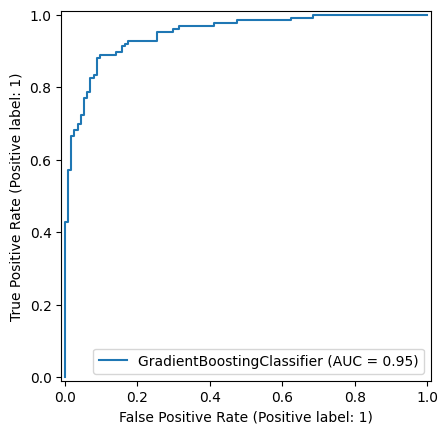

In [0]:
# Use o mlflow para os logs do modelo
with mlflow.start_run(run_name='gradient_boost_disease') as run:

    # Registrar o run_id
    current_run_id = mlflow.active_run().info.run_id

    # Escolha o modelo
    model = sklearn.ensemble.GradientBoostingClassifier(random_state=0)

    # Realize o treino do modelo
    model.fit(X_train_scaled, y_train)

    # Realize as predições no dataset de teste
    predicted_probs = model.predict_proba(X_test_scaled)

    # Calcule e plot a curva ROC
    roc_auc = sklearn.metrics.roc_auc_score(y_test, predicted_probs[:,1])
    roc_curve = sklearn.metrics.RocCurveDisplay.from_estimator(model, X_test_scaled, y_test)

    # Salve a curva ROC
    roc_curve.figure_.savefig("roc_curve.png")

    # Faça o registro da AUC da ROC manualmente (não é logada automaticamente)
    mlflow.log_metric("test_auc", roc_auc)

    # Faça o registro da imagem da curva ROC como um artefato
    mlflow.log_artifact("roc_curve.png")

    # Visualize a área da curva ROC
    print("Teste AUC de: {}".format(roc_auc))

In [0]:
# Defina o espaço exploratório para hiperparâmetros
search_space = {
  'n_estimators': scope.int(hp.quniform('n_estimators', 20, 1000, 1)),
  'learning_rate': hp.loguniform('learning_rate', -3, 0),
  'max_depth': scope.int(hp.quniform('max_depth', 2, 5, 1)),
}

def train_model(params):

  # Habilite o autolog
  mlflow.autolog()
  with mlflow.start_run(nested=True):
    model_hp = sklearn.ensemble.GradientBoostingClassifier(
      random_state=0,
      **params
    )
    model_hp.fit(X_train_scaled, y_train)
    predicted_probs = model_hp.predict_proba(X_test_scaled)

    roc_auc = sklearn.metrics.roc_auc_score(y_test, predicted_probs[:,1])
    mlflow.log_metric('test_auc', roc_auc)

    # Configure a perda para -1*auc
    return {'status': STATUS_OK, 'loss': -1*roc_auc}

with mlflow.start_run(run_name='gb_hyperopt') as run:
  # Use hyperopt para buscar os parâmetros para a maior AUC
  best_params = fmin(
    fn=train_model,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    )

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

2025/09/24 17:13:54 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.

🔗 View Logged Model at: https://e2-demo-field-eng.cloud.databricks.com/ml/experiments/2964497923375933/models/m-e51ea1820a354377969f58d36b0d1af5?o=1444828305810485


  2%|▏         | 1/50 [00:05<04:46,  5.86s/trial, best loss: -0.9500139236981342]

2025/09/24 17:14:00 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.

🔗 View Logged Model at: https://e2-demo-field-eng.cloud.databricks.com/ml/experiments/2964497923375933/models/m-55a3e72151ec4193b0d775455b83f0c9?o=1444828305810485


  4%|▍         | 2/50 [00:13<05:27,  6.82s/trial, best loss: -0.9500139236981342]

2025/09/24 17:14:07 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.

🔗 View Logged Model at: https://e2-demo-field-eng.cloud.databricks.com/ml/experiments/2964497923375933/models/m-f80f92102b8748319d9bba2e0237b8a0?o=1444828305810485


  6%|▌         | 3/50 [00:18<04:49,  6.15s/trial, best loss: -0.9500139236981342]

2025/09/24 17:14:13 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.

🔗 View Logged Model at: https://e2-demo-field-eng.cloud.databricks.com/ml/experiments/2964497923375933/models/m-cff275dcdeb048f4b0726c978cbdce63?o=1444828305810485


  8%|▊         | 4/50 [00:24<04:34,  5.98s/trial, best loss: -0.9500139236981342]

2025/09/24 17:14:18 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.

🔗 View Logged Model at: https://e2-demo-field-eng.cloud.databricks.com/ml/experiments/2964497923375933/models/m-efc623dac8a0450e886faecc7b05509f?o=1444828305810485


 10%|█         | 5/50 [00:30<04:27,  5.94s/trial, best loss: -0.9500139236981342]

2025/09/24 17:14:24 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.

🔗 View Logged Model at: https://e2-demo-field-eng.cloud.databricks.com/ml/experiments/2964497923375933/models/m-6269f97a514d4080ab6388a22952db29?o=1444828305810485


 12%|█▏        | 6/50 [00:38<04:59,  6.81s/trial, best loss: -0.9500139236981342]

2025/09/24 17:14:33 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.

🔗 View Logged Model at: https://e2-demo-field-eng.cloud.databricks.com/ml/experiments/2964497923375933/models/m-ed6da998aa9c4b1ebe89f41892ba4775?o=1444828305810485


 14%|█▍        | 7/50 [00:44<04:40,  6.53s/trial, best loss: -0.9500139236981342]

2025/09/24 17:14:39 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.

🔗 View Logged Model at: https://e2-demo-field-eng.cloud.databricks.com/ml/experiments/2964497923375933/models/m-71a8bbbb2433466388b8542c6ee97e08?o=1444828305810485


 16%|█▌        | 8/50 [00:52<04:56,  7.06s/trial, best loss: -0.9500835421888054]

2025/09/24 17:14:47 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.

🔗 View Logged Model at: https://e2-demo-field-eng.cloud.databricks.com/ml/experiments/2964497923375933/models/m-296cee8c2fc042d4987cffb92802f781?o=1444828305810485


 18%|█▊        | 9/50 [00:59<04:49,  7.06s/trial, best loss: -0.9500835421888054]

2025/09/24 17:14:54 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.

🔗 View Logged Model at: https://e2-demo-field-eng.cloud.databricks.com/ml/experiments/2964497923375933/models/m-58fa1efb538c42aa98d81caf5bba39aa?o=1444828305810485


 20%|██        | 10/50 [01:06<04:32,  6.82s/trial, best loss: -0.9510582010582012]

2025/09/24 17:15:00 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.

🔗 View Logged Model at: https://e2-demo-field-eng.cloud.databricks.com/ml/experiments/2964497923375933/models/m-8f0ede18a4964ac8b9f9b9047e4dd2ec?o=1444828305810485


 22%|██▏       | 11/50 [01:13<04:29,  6.91s/trial, best loss: -0.9510582010582012]

2025/09/24 17:15:07 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.

🔗 View Logged Model at: https://e2-demo-field-eng.cloud.databricks.com/ml/experiments/2964497923375933/models/m-7b7faa426f8a4f29845557fd49e5f3af?o=1444828305810485


 24%|██▍       | 12/50 [01:21<04:41,  7.41s/trial, best loss: -0.9510582010582012]

2025/09/24 17:15:16 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.

🔗 View Logged Model at: https://e2-demo-field-eng.cloud.databricks.com/ml/experiments/2964497923375933/models/m-9d5f3a40f8f647fbbd6efd04d9edab6b?o=1444828305810485


 26%|██▌       | 13/50 [01:29<04:38,  7.52s/trial, best loss: -0.9510582010582012]

2025/09/24 17:15:24 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.

🔗 View Logged Model at: https://e2-demo-field-eng.cloud.databricks.com/ml/experiments/2964497923375933/models/m-5bb69494370f4ac68570e29d55e47280?o=1444828305810485


 28%|██▊       | 14/50 [01:37<04:29,  7.47s/trial, best loss: -0.9510582010582012]

2025/09/24 17:15:31 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.

🔗 View Logged Model at: https://e2-demo-field-eng.cloud.databricks.com/ml/experiments/2964497923375933/models/m-286ce31fa2a349728563f2f066fd330c?o=1444828305810485


 30%|███       | 15/50 [01:43<04:10,  7.14s/trial, best loss: -0.9510582010582012]

2025/09/24 17:15:37 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.

🔗 View Logged Model at: https://e2-demo-field-eng.cloud.databricks.com/ml/experiments/2964497923375933/models/m-a176b80d7a274e42b457de9aee556d65?o=1444828305810485


 32%|███▏      | 16/50 [01:50<03:59,  7.05s/trial, best loss: -0.9510582010582012]

2025/09/24 17:15:44 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.

🔗 View Logged Model at: https://e2-demo-field-eng.cloud.databricks.com/ml/experiments/2964497923375933/models/m-18c2c95a56434393ad96fe2cbd21143a?o=1444828305810485


 34%|███▍      | 17/50 [01:56<03:47,  6.89s/trial, best loss: -0.9510582010582012]

2025/09/24 17:15:51 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.

🔗 View Logged Model at: https://e2-demo-field-eng.cloud.databricks.com/ml/experiments/2964497923375933/models/m-97609208a4b245a1b621d7c62e4a5dd2?o=1444828305810485


 36%|███▌      | 18/50 [02:03<03:34,  6.70s/trial, best loss: -0.9510582010582012]

2025/09/24 17:15:57 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.

🔗 View Logged Model at: https://e2-demo-field-eng.cloud.databricks.com/ml/experiments/2964497923375933/models/m-e8cf8aae0f554c13b5c5d04eefa4c3d2?o=1444828305810485


 38%|███▊      | 19/50 [02:09<03:23,  6.58s/trial, best loss: -0.9517543859649124]

2025/09/24 17:16:03 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.

🔗 View Logged Model at: https://e2-demo-field-eng.cloud.databricks.com/ml/experiments/2964497923375933/models/m-bffdd7af74ca4964997349c174612527?o=1444828305810485


 40%|████      | 20/50 [02:14<03:08,  6.28s/trial, best loss: -0.9517543859649124]

2025/09/24 17:16:09 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.

🔗 View Logged Model at: https://e2-demo-field-eng.cloud.databricks.com/ml/experiments/2964497923375933/models/m-a1fa56f34d854c798f99057966ba83b4?o=1444828305810485


 42%|████▏     | 21/50 [02:21<03:00,  6.24s/trial, best loss: -0.9517543859649124]

2025/09/24 17:16:15 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.

🔗 View Logged Model at: https://e2-demo-field-eng.cloud.databricks.com/ml/experiments/2964497923375933/models/m-1a0bebe905fe404b85dd4ba727b226d6?o=1444828305810485


 44%|████▍     | 22/50 [02:27<02:56,  6.30s/trial, best loss: -0.9517543859649124]

2025/09/24 17:16:22 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.

🔗 View Logged Model at: https://e2-demo-field-eng.cloud.databricks.com/ml/experiments/2964497923375933/models/m-2af0e48c93a74e299ae72d4ebe20f028?o=1444828305810485


 46%|████▌     | 23/50 [02:33<02:46,  6.17s/trial, best loss: -0.9517543859649124]

2025/09/24 17:16:27 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.

🔗 View Logged Model at: https://e2-demo-field-eng.cloud.databricks.com/ml/experiments/2964497923375933/models/m-8108dc06cc304dd792077ac8daa84422?o=1444828305810485


 48%|████▊     | 24/50 [02:40<02:45,  6.35s/trial, best loss: -0.9517543859649124]

2025/09/24 17:16:34 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.

🔗 View Logged Model at: https://e2-demo-field-eng.cloud.databricks.com/ml/experiments/2964497923375933/models/m-5765339c22b946448b20b19faf942a7b?o=1444828305810485


 50%|█████     | 25/50 [02:45<02:34,  6.16s/trial, best loss: -0.9517543859649124]

2025/09/24 17:16:40 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.

🔗 View Logged Model at: https://e2-demo-field-eng.cloud.databricks.com/ml/experiments/2964497923375933/models/m-4c59655d56164f30a0905b00e197289e?o=1444828305810485


 52%|█████▏    | 26/50 [02:52<02:29,  6.23s/trial, best loss: -0.9517543859649124]

2025/09/24 17:16:46 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.

🔗 View Logged Model at: https://e2-demo-field-eng.cloud.databricks.com/ml/experiments/2964497923375933/models/m-3053273d6e21480ea44b71307bcdcde0?o=1444828305810485


 54%|█████▍    | 27/50 [02:58<02:19,  6.08s/trial, best loss: -0.9517543859649124]

2025/09/24 17:16:52 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.

🔗 View Logged Model at: https://e2-demo-field-eng.cloud.databricks.com/ml/experiments/2964497923375933/models/m-9293e496577949f8b5bbb5dd5bc9077c?o=1444828305810485


 56%|█████▌    | 28/50 [03:04<02:17,  6.26s/trial, best loss: -0.9517543859649124]

2025/09/24 17:16:59 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.

🔗 View Logged Model at: https://e2-demo-field-eng.cloud.databricks.com/ml/experiments/2964497923375933/models/m-7046d37ff86d43e4989c09880476993d?o=1444828305810485


 58%|█████▊    | 29/50 [03:10<02:07,  6.07s/trial, best loss: -0.9517543859649124]

2025/09/24 17:17:04 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.

🔗 View Logged Model at: https://e2-demo-field-eng.cloud.databricks.com/ml/experiments/2964497923375933/models/m-d85a473034d6447f8a36ecbec460f491?o=1444828305810485


 60%|██████    | 30/50 [03:16<02:02,  6.10s/trial, best loss: -0.9517543859649124]

2025/09/24 17:17:11 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.

🔗 View Logged Model at: https://e2-demo-field-eng.cloud.databricks.com/ml/experiments/2964497923375933/models/m-0638d491bcef49318eb3d4532fd3fdd5?o=1444828305810485


 62%|██████▏   | 31/50 [03:23<02:03,  6.48s/trial, best loss: -0.9517543859649124]

2025/09/24 17:17:18 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.

🔗 View Logged Model at: https://e2-demo-field-eng.cloud.databricks.com/ml/experiments/2964497923375933/models/m-0656e5a39de14197b82fe03b9012cd4f?o=1444828305810485


 64%|██████▍   | 32/50 [03:32<02:08,  7.13s/trial, best loss: -0.9517543859649124]

2025/09/24 17:17:27 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.

🔗 View Logged Model at: https://e2-demo-field-eng.cloud.databricks.com/ml/experiments/2964497923375933/models/m-3ad56a6ea28845b6a542605a2ac4e555?o=1444828305810485


 66%|██████▌   | 33/50 [03:43<02:22,  8.40s/trial, best loss: -0.9517543859649124]

2025/09/24 17:17:38 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.

🔗 View Logged Model at: https://e2-demo-field-eng.cloud.databricks.com/ml/experiments/2964497923375933/models/m-70da236844f74ef3a8b1bc4946b82ce5?o=1444828305810485


 68%|██████▊   | 34/50 [03:50<02:04,  7.79s/trial, best loss: -0.9517543859649124]

2025/09/24 17:17:45 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.

🔗 View Logged Model at: https://e2-demo-field-eng.cloud.databricks.com/ml/experiments/2964497923375933/models/m-207397ddf67045bbaa088d2ee2c34d7d?o=1444828305810485


 70%|███████   | 35/50 [03:56<01:50,  7.40s/trial, best loss: -0.9517543859649124]

2025/09/24 17:17:51 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.

🔗 View Logged Model at: https://e2-demo-field-eng.cloud.databricks.com/ml/experiments/2964497923375933/models/m-355e1c62f962476bb7d44f5b0b814765?o=1444828305810485


 72%|███████▏  | 36/50 [04:03<01:39,  7.12s/trial, best loss: -0.9517543859649124]

2025/09/24 17:17:57 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.

🔗 View Logged Model at: https://e2-demo-field-eng.cloud.databricks.com/ml/experiments/2964497923375933/models/m-db49a6323eab453ab61fddd9cc0cb074?o=1444828305810485


 74%|███████▍  | 37/50 [04:09<01:28,  6.80s/trial, best loss: -0.9517543859649124]

2025/09/24 17:18:03 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.

🔗 View Logged Model at: https://e2-demo-field-eng.cloud.databricks.com/ml/experiments/2964497923375933/models/m-f6758afccd8f47f3aced69f6d4d3ed5c?o=1444828305810485


 76%|███████▌  | 38/50 [04:16<01:22,  6.84s/trial, best loss: -0.9517543859649124]

2025/09/24 17:18:10 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.

🔗 View Logged Model at: https://e2-demo-field-eng.cloud.databricks.com/ml/experiments/2964497923375933/models/m-903afc6f8a0a4b95b24d7ad42e4cc0fc?o=1444828305810485


 78%|███████▊  | 39/50 [04:23<01:15,  6.84s/trial, best loss: -0.9517543859649124]

2025/09/24 17:18:17 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.

🔗 View Logged Model at: https://e2-demo-field-eng.cloud.databricks.com/ml/experiments/2964497923375933/models/m-01de3d7afd254cebb75f0bd1ffd69dfd?o=1444828305810485


 80%|████████  | 40/50 [04:28<01:04,  6.46s/trial, best loss: -0.9517543859649124]

2025/09/24 17:18:23 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.

🔗 View Logged Model at: https://e2-demo-field-eng.cloud.databricks.com/ml/experiments/2964497923375933/models/m-a54ad8a9612745268dd77853dd160b57?o=1444828305810485


 82%|████████▏ | 41/50 [04:35<00:59,  6.65s/trial, best loss: -0.9517543859649124]

2025/09/24 17:18:30 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.

🔗 View Logged Model at: https://e2-demo-field-eng.cloud.databricks.com/ml/experiments/2964497923375933/models/m-6468bc9c1f784a289ade5d456bba8b38?o=1444828305810485


 84%|████████▍ | 42/50 [04:42<00:52,  6.60s/trial, best loss: -0.9517543859649124]

2025/09/24 17:18:36 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.

🔗 View Logged Model at: https://e2-demo-field-eng.cloud.databricks.com/ml/experiments/2964497923375933/models/m-969b8284f9c642bf912221c05ebecb0f?o=1444828305810485


 86%|████████▌ | 43/50 [04:48<00:45,  6.45s/trial, best loss: -0.9524505708716235]

2025/09/24 17:18:42 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.

🔗 View Logged Model at: https://e2-demo-field-eng.cloud.databricks.com/ml/experiments/2964497923375933/models/m-d1c83fef93e046f7a4d3f1413938f426?o=1444828305810485


 88%|████████▊ | 44/50 [04:54<00:38,  6.37s/trial, best loss: -0.9524505708716235]

2025/09/24 17:18:48 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.

🔗 View Logged Model at: https://e2-demo-field-eng.cloud.databricks.com/ml/experiments/2964497923375933/models/m-d54b6fca4c584cf9823329522937edaa?o=1444828305810485


 90%|█████████ | 45/50 [05:00<00:31,  6.24s/trial, best loss: -0.9524505708716235]

2025/09/24 17:18:54 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.

🔗 View Logged Model at: https://e2-demo-field-eng.cloud.databricks.com/ml/experiments/2964497923375933/models/m-5caf5a446ff64a569255ce9c9ae4afe5?o=1444828305810485


 92%|█████████▏| 46/50 [05:06<00:24,  6.20s/trial, best loss: -0.9524505708716235]

2025/09/24 17:19:00 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.

🔗 View Logged Model at: https://e2-demo-field-eng.cloud.databricks.com/ml/experiments/2964497923375933/models/m-10de1a32c84f4536829faf9529622707?o=1444828305810485


 94%|█████████▍| 47/50 [05:13<00:18,  6.30s/trial, best loss: -0.9524505708716235]

2025/09/24 17:19:07 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.

🔗 View Logged Model at: https://e2-demo-field-eng.cloud.databricks.com/ml/experiments/2964497923375933/models/m-3b947fc140464e0682d01757a410c910?o=1444828305810485


 96%|█████████▌| 48/50 [05:20<00:13,  6.52s/trial, best loss: -0.9524505708716235]

2025/09/24 17:19:14 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.

🔗 View Logged Model at: https://e2-demo-field-eng.cloud.databricks.com/ml/experiments/2964497923375933/models/m-cf0ced56f9ee40d99a13f4c51b0b692c?o=1444828305810485


 98%|█████████▊| 49/50 [05:26<00:06,  6.42s/trial, best loss: -0.9524505708716235]

2025/09/24 17:19:20 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.

🔗 View Logged Model at: https://e2-demo-field-eng.cloud.databricks.com/ml/experiments/2964497923375933/models/m-b4488f4545a0448c939a4691ed7f6161?o=1444828305810485


100%|██████████| 50/50 [05:33<00:00,  6.66s/trial, best loss: -0.9524505708716235]


In [0]:
# Ordene as execuções pela AUC e pela mais recente
best_runs = mlflow.search_runs(
  order_by=['metrics.test_auc DESC', 'start_time DESC'],
  max_results=10,
)
best_runs_no_overfitting = best_runs[best_runs['metrics.test_auc'] != 1]
best_runs_no_overfitting

run_id  ...             tags.mlflow.rootRunId
1  6ddddbfb66b04931a15d3046d38129c4  ...  57afade6113a43f68f0ea859820e3d79
2  068b6109187b43a6bded9d3544589a20  ...  c945a8a832d343a3948bc71e4cd1b5c9
3  74497b1ada4b4ed69258602fd93f822c  ...  c945a8a832d343a3948bc71e4cd1b5c9
4  6d52e73c46fb4e6c811f61ee33d18265  ...  7d67ba3a29ac481e98547e95d34eec10
5  596bfefcc5e0431ea26492e6f397a4ed  ...  7d67ba3a29ac481e98547e95d34eec10
6  17245bc180924331bc089aa1d902c61b  ...  c945a8a832d343a3948bc71e4cd1b5c9
7  7e823427e53e495bb713eab3a7ca7f2f  ...  d9030dc3624f4adc80c4ec63541c7a11
8  d7488fa7358e4e37848ded3358877168  ...  f782a10443e641ed898e885aff650dca
9  eb9ce2954866461e9030d78a24bcbb33  ...  4477b0cfb2d2484d97f6b20db1680bcf

[9 rows x 54 columns]

In [0]:
best_run=best_runs_no_overfitting.iloc[0]
print('Best Run')
print('AUC: {}'.format(best_run["metrics.test_auc"]))
print('Num Estimators: {}'.format(best_run["params.n_estimators"]))
print('Max Depth: {}'.format(best_run["params.max_depth"]))
print('Learning Rate: {}'.format(best_run["params.learning_rate"]))

Best Run
AUC: 0.9535644667223614
Num Estimators: 149
Max Depth: 5
Learning Rate: 0.19247438287362714


In [0]:
# Recupere o run_id da melhor execução
run_id = best_run["run_id"]

# Carregue o modelo salvo pelo MLflow
model_uri = f"runs:/{run_id}/model"
best_model = mlflow.sklearn.load_model(model_uri)

# Teste o best_model em um predict
y_pred_best = best_model.predict(X_test_scaled)
display(y_pred_best)

array([1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0])

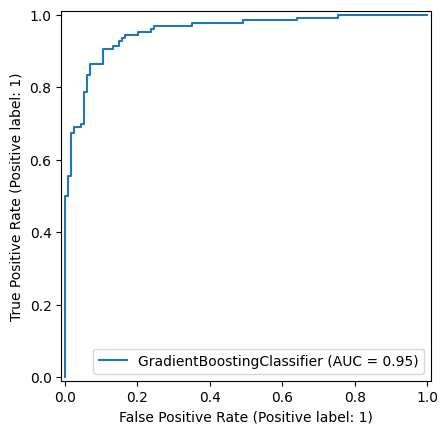

In [0]:
# Realize as predições no dataset de teste com os novos parâmetros e plote a curva ROC
predicted_probs_new = best_model.predict_proba(X_test_scaled)
roc_auc_new = sklearn.metrics.roc_auc_score(y_test, predicted_probs_new[:,1])
roc_curve_new = sklearn.metrics.RocCurveDisplay.from_estimator(best_model, X_test_scaled, y_test)

In [0]:
# Realize o registro do modelo
model_uri = 'runs:/{run_id}/model'.format(
    run_id=best_run.run_id
  )

mlflow.register_model(model_uri, f"{CATALOG_NAME}.{SCHEMA_NAME}.modelo_classificacao_disease")

Successfully registered model 'baraldi_catalog_new.classification.modelo_classificacao_disease'.


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

🔗 Created version '1' of model 'baraldi_catalog_new.classification.modelo_classificacao_disease': https://e2-demo-field-eng.cloud.databricks.com/explore/data/models/baraldi_catalog_new/classification/modelo_classificacao_disease/version/1?o=1444828305810485


<ModelVersion: aliases=[], creation_timestamp=1758734374828, current_stage=None, deployment_job_state=<ModelVersionDeploymentJobState: current_task_name='', job_id='', job_state='DEPLOYMENT_JOB_CONNECTION_STATE_UNSPECIFIED', run_id='', run_state='DEPLOYMENT_JOB_RUN_STATE_UNSPECIFIED'>, description='', last_updated_timestamp=1758734375794, metrics=[], model_id='', name='baraldi_catalog_new.classification.modelo_classificacao_disease', params=[], run_id='6ddddbfb66b04931a15d3046d38129c4', run_link=None, source='dbfs:/databricks/mlflow-tracking/2964497923375933/6ddddbfb66b04931a15d3046d38129c4/artifacts/model', status='READY', status_message='', tags={}, user_id='daniel.baraldi@databricks.com', version='1'>

In [0]:
# Confirme que o modelo foi registrado e está governado pelo Unity Catalog

![Model.png](./Model.png "Model.png")

In [0]:
# Sirva o modelo em um endpoint
client = get_deploy_client("databricks")
try:
  client.delete_endpoint("unity-catalog-model-classification-endpoint")
except:
  pass
endpoint = client.create_endpoint(
      name="unity-catalog-model-classification-endpoint",
      config={
          "served_entities": [
              {
                  "name": "modelo_classificacao_disease_served",
                  "entity_name": f"{CATALOG_NAME}.{SCHEMA_NAME}.modelo_classificacao_disease",
                  "entity_version": 1,
                  "workload_size": "Small",
                  "scale_to_zero_enabled": False,
                  "request_tracing_enabled": True
              }
          ],
          "traffic_config": {
              "routes": [
                  {
                      "served_model_name": "modelo_classificacao_disease_served",
                      "traffic_percentage": 100
                  }
              ]
          }
      }
  )

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9b5918c9-1ddb-453a-a7f1-548cd0c3c4b8/lib/python3.12/site-packages/mlflow/deployments/databricks/__init__.py:465: UserWarning: Passing 'name', 'config', and 'route_optimized' as separate parameters is deprecated. Please pass the full API request payload as a single dictionary in the 'config' parameter.
  warnings.warn("\n".join(warnings_list), UserWarning)


In [0]:
# A execução acima pode levar alguns minutos para terminar. É possível acompanhar pela aba de models e escolhendo o modelo em questão e entrando no active endpoint indicado

![FUPEndpoint.png](./FUPEndpoint.png "FUPEndpoint.png")

In [0]:
# Faça um request no endpoint do modelo para confirmar que está funcionando
import os
import requests
import pandas as pd
import json
import getpass

token = getpass.getpass("Digite seu token: ")

# Dado de entrada em formato CSV
dado = '''idade,sexo,pressao_sistolica,pressao_diastolica,colesterol,batimento,imc,glicose,tabagismo
59.0,1,156.0,105.0,254.0,72.0,27.7,182.0,1
'''

# Converter CSV para DataFrame
from io import StringIO
dataset = pd.read_csv(StringIO(dado))

# Definir endpoint e headers de autorização
url = 'https://e2-demo-field-eng.cloud.databricks.com/serving-endpoints/unity-catalog-model-classification-endpoint/invocations'
headers = {
    'Authorization': f'Bearer {token}',
    'Content-Type': 'application/json'
}

# Montar payload no formato dataframe_split
ds_dict = {'dataframe_split': dataset.to_dict(orient='split')}
data_json = json.dumps(ds_dict, allow_nan=True)

# Fazer o request (POST)
response = requests.post(url, headers=headers, data=data_json)
if response.status_code != 200:
    raise Exception(f'Request failed with status {response.status_code}, {response.text}')
print(response.json())


Digite seu token:  [REDACTED]

{'predictions': [1]}


### Feature Store

In [0]:
# Instale a biblioteca de feature engineering
%pip install databricks-feature-engineering

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
# Reinicie o python
dbutils.library.restartPython()

In [0]:
# Substitua o catálogo e o schema que irá usar e crie
CATALOG_NAME = "baraldi_catalog_new"
SCHEMA_NAME = "classification"

spark.sql(f"CREATE CATALOG IF NOT EXISTS {CATALOG_NAME}")
spark.sql(f"CREATE SCHEMA IF NOT EXISTS {CATALOG_NAME}.{SCHEMA_NAME}")

DataFrame[]

In [0]:
# Importe as bibliotecas necessárias
from databricks.feature_engineering import FeatureEngineeringClient

In [0]:
# Instancie o FeatureEngineeringClient
fe = FeatureEngineeringClient()

In [0]:
# Crie uma nova feature table a partir da tabela Delta existente
spark.sql(f"ALTER TABLE {CATALOG_NAME}.{SCHEMA_NAME}.dataset_disease ALTER COLUMN id SET NOT NULL")

DataFrame[]

In [0]:
# Crie uma constraint para a primary key
spark.sql(f"ALTER TABLE {CATALOG_NAME}.{SCHEMA_NAME}.dataset_disease ADD CONSTRAINT id_pk PRIMARY KEY(id)")

DataFrame[]

In [0]:
# Visualize os dados da feature table
display(fe.get_table(name=f"{CATALOG_NAME}.{SCHEMA_NAME}.dataset_disease"))

<FeatureTable: name='baraldi_catalog_new.classification.dataset_disease', table_id='5a2d7448-8754-4a04-93d3-69ea560ae73f', description='', primary_keys=['id'], partition_columns=[], features=['id',
 'idade',
 'sexo',
 'pressao_sistolica',
 'pressao_diastolica',
 'colesterol',
 'batimento',
 'imc',
 'glicose',
 'tabagismo',
 'doenca_cardiaca'], creation_timestamp=1758734015121, online_stores=[], notebook_producers=[], job_producers=[], table_data_sources=[], path_data_sources=[], custom_data_sources=[], timestamp_keys=[], tags={}>

### Logs e AI Gateway

In [0]:
# Configure o AI Gateway para que o tracing esteja habilitado. Garanta que está conforme abaixo.

![Logs0.png](./Logs0.png "Logs0.png")

![Logs.png](./Logs.png "Logs.png")

![Logs4.png](./Logs4.png "Logs4.png")

In [0]:
import mlflow

# Faça um request no endpoint do modelo para confirmar que está funcionando
import os
import requests
import pandas as pd
import json
import getpass

token = getpass.getpass("Digite seu token: ")

# Dado de entrada em formato CSV
dado = '''idade,sexo,pressao_sistolica,pressao_diastolica,colesterol,batimento,imc,glicose,tabagismo
59.0,1,156.0,105.0,254.0,72.0,27.7,182.0,1
'''

# Converter CSV para DataFrame
from io import StringIO
dataset = pd.read_csv(StringIO(dado))

# Definir endpoint e headers de autorização
url = 'https://e2-demo-field-eng.cloud.databricks.com/serving-endpoints/unity-catalog-model-classification-endpoint/invocations'
headers = {
    'Authorization': f'Bearer {token}',
    'Content-Type': 'application/json'
}

# Montar payload no formato dataframe_split
ds_dict = {'dataframe_split': dataset.to_dict(orient='split')}
data_json = json.dumps(ds_dict, allow_nan=True)

# Fazer o request (POST)
response = requests.post(url, headers=headers, data=data_json)
if response.status_code != 200:
    raise Exception(f'Request failed with status {response.status_code}, {response.text}')
print(response.json())

Digite seu token:  [REDACTED]

{'predictions': [1]}


In [0]:
# Verifique os logs registrados nas system tables. Pode levar algum tempo até aparecer.

![Logs3.png](./Logs3.png "Logs3.png")